In [3]:
import tensorflow as tf
import wandb
import dlomix
import dlomix.losses
from dlomix.data import load_processed_dataset
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [4]:
MODEL_DIR = '/cmnfs/proj/prosit_astral/bmpc_dlomix_group/models/baseline_models/noptm_baseline_full_bs1024_naivemods/'
RUN_NAME = 'd961f940-d142-4102-9775-c1f8b4373c91'

In [53]:
model = tf.keras.models.load_model(
    MODEL_DIR + RUN_NAME + '.keras', 
    # custom_objects={'masked_spectral_distance': dlomix.losses.masked_spectral_distance}
    )
print(model.summary())

Model: "prosit_intensity_predictor_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  432       
                                                                 
 sequential_10 (Sequential)  (None, 30, 512)           1996800   
                                                                 
 sequential_11 (Sequential)  multiple                  4608      
                                                                 
 sequential_12 (Sequential)  (None, 29, 512)           1576806   
                                                                 
 encoder_att (AttentionLaye  multiple                  542       
 r)                                                              
                                                                 
 sequential_13 (Sequential)  multiple                  0         
                                      

In [5]:
# check performance of model on the test set without modifications
baseline_data = load_processed_dataset('/cmnfs/proj/prosit_astral/bmpc_dlomix_group/datasets/processed/noptm_baseline_small_bs1024')

In [6]:
len(baseline_data.tensor_train_data)

2024-06-24 14:40:36.627241: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


8

In [7]:
from dlomix.losses import masked_spectral_distance
sd_baseline = list()
for batch, y_true in baseline_data.tensor_train_data:
    print('Max value: ', batch['modified_sequence'].numpy().max())
    print('Min value: ', batch['modified_sequence'].numpy().min())
    # y_pred = model.predict(batch)
    # sd_baseline.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0
Max value:  56
Min value:  0


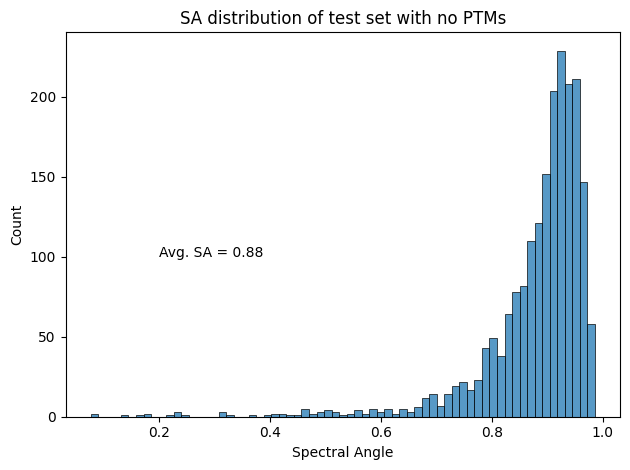

In [20]:
# distribution of spectral angles on baseline test set
sa_baseline = [1 - sd for sd in sd_baseline]
avg_sa_baseline = np.mean(sa_baseline)
p = sns.histplot(sa_baseline)
p.text(0.2, 100, f'Avg. SA = {avg_sa_baseline:.2}')
plt.title('SA distribution of test set with no PTMs')
plt.xlabel('Spectral Angle')
plt.tight_layout()

In [8]:
# check the shape of the weights of the embedding layer
# 58 for the alphabet size and 16 for the embeddings
# each input sequence of shape (n, 1) is mapped to the respective embedding resulting in shape (n, 16)
model.layers[0].get_weights()[0].shape

(58, 16)

In [178]:
# alphabet that contains all naive mods as well as the K modification Fromyl -> dataset at /cmnfs/data/proteomics/Prosit_PTMs/21PTMs/Kmod_Formyl.parquet
from dlomix.constants import ALPHABET_NAIVE_MODS
ALPHABET_NAIVE_MODS.update({'K[UNIMOD:122]': 26})
print(ALPHABET_NAIVE_MODS)

{'C[UNIMOD:4]': 24, 'M[UNIMOD:35]': 25, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '[]-': 21, '-[]': 22, '[UNIMOD:737]-': 21, 'K[UNIMOD:122]': 26}


In [179]:
# load a small dataset which contains only the new modification K[UNIMOD:122] as well as the other ones present in ALPHABET_NAIVE_MODS
data = load_processed_dataset('/cmnfs/proj/prosit_astral/bmpc_dlomix_group/datasets/processed/kmod_formyl')

In [180]:
from collections import Counter
c = Counter()
total_seqs = 0
for batch, _ in data.tensor_train_data:
    for seq in batch['modified_sequence'].numpy():
        c.update(seq)
        total_seqs += 1
    for k, v in ALPHABET_NAIVE_MODS.items():
        if v == batch['modified_sequence'].numpy().max():
            print(f'Modification {k} is correctly encoded and present in the current batch')

Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch
Modification K[UNIMOD:122] is correctly encoded and present in the current batch


In [208]:
sorted(list(c.keys()))

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 24,
 25,
 26]

In [13]:
print(f'Total of {c[26]} istances of the new modification in {total_seqs} are present')

Total of 5807 istances of the new modification in 7169 are present


In [14]:
# predict the intensities and calculate spectral distance between predictions and true intensities
sd_new_mod = list()
for batch, y_true in data.tensor_val_data:
    y_pred = model.predict(batch)
    sd_new_mod.extend(masked_spectral_distance(y_true=y_true, y_pred=y_pred).numpy())

25/25 [==============================] - 2s 83ms/step


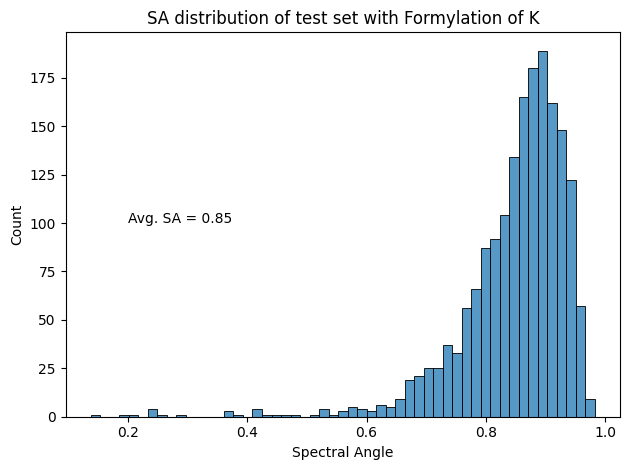

In [22]:
# distribution of spectral angles on the dataset with new modification
sa_new_mod = [1 - sd for sd in sd_new_mod]
avg_sa_new_mod = np.mean(sa_new_mod)
q = sns.histplot(sa_new_mod)
q.text(0.2, 100, f'Avg. SA = {avg_sa_new_mod:.2}')
plt.title('SA distribution of test set with Formylation of K')
plt.xlabel('Spectral Angle')
plt.tight_layout()

### Try to only allow the new embeddings to train

In [32]:
from dlomix.models import PrositIntensityPredictor
def change_input_layer(model: PrositIntensityPredictor, modifications: list = None) -> None:
    if modifications:
        for new_mod in modifications:
            model.alphabet.update({new_mod: max(model.alphabet.values()) + 1})

    model.embedding = tf.keras.layers.Embedding(
        input_dim=len(model.alphabet) + 2,
        output_dim=model.embedding_output_dim,
        input_length=model.seq_length,
        name='embedding'
    )

In [54]:
# get the weights from the old embedding layer
old_embedding_weights = model.layers[0].get_weights()[0]
print(f'Shape of the old embeddings: {old_embedding_weights.shape}')

Shape of the old embeddings: (27, 16)


In [55]:
# initialize the new embedding weights with a random initialization and the new shape -> use updated alphabet
new_embedding_weights = tf.Variable(tf.random.normal([len(model.alphabet) + 3, old_embedding_weights.shape[1]]))
print(f'Shape of weights for new embedding layer: {new_embedding_weights.shape}')

Shape of weights for new embedding layer: (28, 16)


In [57]:
# set the old embedding weights as the first len(model.old_alphabet) + 2 embeddings
new_embedding_weights[:old_embedding_weights.shape[0], :].assign(old_embedding_weights)
# randomly initialize the new embedding dimensions
new_embedding_weights[old_embedding_weights.shape[0]:, :].assign(tf.random.normal([1, old_embedding_weights.shape[1]]))
print(f'New embeddings are the same as old embeddings: {np.all(old_embedding_weights == new_embedding_weights[:old_embedding_weights.shape[0], :])}')

New embeddings are the same as old embeddings: True


In [58]:
# change the input layer such that new modification can be implemented
change_input_layer(model, ['K[UNIMOD:122]'])

In [61]:
# build the new layer to initialize random weights
model.get_layer('embedding').build((None,))
print(f'Shape of newly build embedding layer is: {model.get_layer("embedding").get_weights()[0].shape}')

Shape of newly build embedding layer is: (28, 16)


/cmnfs/home/f.kapitza/miniconda3/envs/dlomix/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [62]:
# set the old weights + the new embedding layer to the layer weights
model.get_layer('embedding').set_weights([new_embedding_weights])

In [63]:
print(f'Embedding layer weight shape after changing output layer: {model.get_layer(name="embedding").get_weights()[0].shape}')
print(f'The weights from the embedding layer are the same as the old embedding layer for the first n-dimensions: {np.all(old_embedding_weights == model.get_layer("embedding").get_weights()[0][:old_embedding_weights.shape[0], :])}')

Embedding layer weight shape after changing output layer: (28, 16)
The weights from the embedding layer are the same as the old embedding layer for the first n-dimensions: True


In [67]:
# Test if the first n dimensions (the old embeddings) can be frozen
weights = model.get_layer('embedding').trainable_weights[0]

### Test if one can apply a constraint during training to only allow the new embeddings to train

In [78]:
trainable_mask = tf.scatter_nd(
    indices=tf.expand_dims([27], axis=1),
    updates=tf.ones_like([27], dtype=tf.float32),
    shape=[28]
)
frozen_mask = 1.0 - trainable_mask

In [80]:
weights = model.get_layer('embedding').get_weights()[0]

In [140]:
from tensorflow.keras.constraints import Constraint
import keras.backend as K
class FixWeights(Constraint):
    def __init__(self, old_weights):
        self.old_weights = old_weights
    def __call__(self, w):
        return K.concatenate([self.old_weights, w[self.old_weights.shape[0]:]], axis=0)

In [ ]:
# Example usage
vocab_size = 28
embedding_dim = 16

old_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=30),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

old_model.compile(optimizer='adam', loss='binary_crossentropy')

# Dummy data
inputs = tf.random.uniform((15, 30), maxval=vocab_size, dtype=tf.int32)
labels = tf.random.uniform((15,), maxval=2, dtype=tf.int32)

old_model.fit(inputs, labels, epochs=100)

In [164]:
# get old model embedding weights
old_weights = old_model.layers[0].get_weights()[0]
old_weights.shape

(28, 16)

In [165]:
# build a new model with the FixWeights constraint
new_vocab_size = vocab_size + 1
new_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=new_vocab_size, output_dim=embedding_dim, input_length=30, embeddings_constraint=FixWeights(old_weights=old_weights)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

new_model.compile(optimizer='adam', loss='binary_crossentropy')

# Dummy data
new_inputs = tf.random.uniform((15, 30), maxval=new_vocab_size, dtype=tf.int32)
new_labels = tf.random.uniform((15,), maxval=2, dtype=tf.int32)

In [159]:
# get the untrained last embedding slice 
new_embedding = new_model.layers[0].get_weights()[0][27]
new_embedding.shape

(16,)

In [ ]:
new_model.fit(new_inputs, new_labels, epochs=100)

In [151]:
new_weights = new_model.layers[0].get_weights()[0]
new_weights.shape

(29, 16)

In [155]:
print(f'The old and the new embedding weights are the same: {np.all(old_weights[:27] == new_weights[:27])}')

The old and the new embedding weights are the same: True


In [162]:
new_embedding_trained = new_model.layers[0].get_weights()[0][27]
print(f'The new embedding layer is the same as before training: {np.any(new_embedding == new_embedding_trained)}')

The new embedding layer is the same as before training: False


-> all the old embeddings stayed the same, the new embedding was trained

### See if the constraint approach can be applied to the prosit network

In [253]:
from dlomix.models import PrositIntensityPredictor
import keras.backend as K
from tensorflow.keras.constraints import Constraint

class FixWeights(Constraint):
    def __init__(self, old_weights):
        self.old_weights = old_weights
        self.freeze_weights = True

    def __call__(self, w):
        if self.freeze_weights:
            new_w =  K.concatenate([self.old_weights[:self.old_weights.shape[0] - 1], w[self.old_weights.shape[0] - 1:]], axis=0)
            return new_w
        else:
            return w

    

def change_input_layer(model: PrositIntensityPredictor, modifications: list = None, freeze_old_embeds: bool = False) -> None:
    if modifications:
        model.alphabet.update({k: i for i, k in enumerate(modifications, start=len(model.alphabet) + 1)})
        
    embeddings_constraint = None
    if freeze_old_embeds:
        # if added names to the model, replace get_layer index with name 
        trained_embeds_weights = model.layers[0].get_weights()[0]
        embeddings_constraint = FixWeights(trained_embeds_weights)

    model.embedding = tf.keras.layers.Embedding(
        input_dim=len(model.alphabet) + 2,
        output_dim=model.embedding_output_dim,
        input_length=model.seq_length,
        embeddings_constraint=embeddings_constraint,
        name='embedding'
        )

In [260]:
# use a Custom Callback to check if the weights of the new embedding layer changes
class PrintWeights(tf.keras.callbacks.Callback):
    def __init__(self, index):
        super().__init__()
        self.index = index
    def on_epoch_end(self, epoch, logs=None):
        print(self.model.get_layer('embedding').get_weights()[0][self.index])

In [240]:
# load a small dataset containing the new modification
data = load_processed_dataset('/cmnfs/proj/prosit_astral/bmpc_dlomix_group/datasets/processed/kmod_formyl')

In [241]:
# load the model
model = tf.keras.models.load_model(MODEL_DIR + RUN_NAME + '.keras')

In [242]:
# get the trained weights from the embedding layer
old_w = model.layers[0].get_weights()[0]
old_w.shape

(27, 16)

In [243]:
# change the embedding layer 
change_input_layer(model, modifications=['K[UNIMOD:122]'], freeze_old_embeds=True)

In [244]:
# freeze everything except the embedding layer
def freeze_model(model:dlomix.models.prosit.PrositIntensityPredictor, trainable_first_layer:bool = False, trainable_last_layer:bool = False) -> None:
    model.trainable = True 
    for lay in model.layers:
        try:
            for sublay in lay.layers:
                sublay.trainable = False
        except (AttributeError):
            lay.trainable = False

    if (trainable_first_layer):
        first_layer = model.get_layer(name="embedding")
        first_layer.trainable = True

    if (trainable_last_layer):
        last_layer = model.get_layer(name = "sequential_4").get_layer(name = "time_dense")
        last_layer.trainable = True
freeze_model(model, trainable_first_layer=True)

In [245]:
# check the embeddings constraint
model.get_layer('embedding').embeddings_constraint

In [246]:
# recompile the model
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001), loss=masked_spectral_distance)

In [247]:
model.alphabet

{'C[UNIMOD:4]': 24,
 'M[UNIMOD:35]': 25,
 'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20,
 '[]-': 21,
 '-[]': 22,
 '[UNIMOD:737]-': 21,
 'K[UNIMOD:122]': 26}

In [ ]:
# train the model on the dataset containing the new modification for two epochs
model.fit(
    data.tensor_train_data,
    validation_data=data.tensor_val_data,
    epochs=2,
    callbacks=[PrintWeights(index=model.alphabet['K[UNIMOD:122]'])]
)

In [249]:
# retrieve the weigths of the new embedding layer
new_w = model.get_layer('embedding').get_weights()[0]
new_w.shape

(28, 16)

In [251]:
# check if the old embedding weights are the same
print(f'The weights for the old embeddings are the same as before training: {np.all(old_w[:26] == new_w[:26])}')

The weights for the old embeddings are the same as before training: True


In [252]:
print(f'The weights of the new embedding did not change: {np.all(old_w[26] == new_w[26])}')

The weights of the new embedding did not change: False


### Check if the constraint can be lifted after a specified number of epochs

In [125]:
from keras.callbacks import Callback
class ReleaseTrainedEmbeddings(Callback):
    def __init__(self, removal_epoch):
        super().__init__()
        self.removal_epoch = removal_epoch
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.removal_epoch:
            print(f'Removing Constraint from the Embedding layer at the end of epoch {epoch + 1}')
            print(f"Freeze Weight parameter of embeddings constraint: {self.model.get_layer('embedding').embeddings_constraint.freeze_weights}")
            self.model.get_layer('embedding').embeddings_constraint.freeze_weights = False
            print(f"Freeze Weight parameter of embeddings constraint: {self.model.get_layer('embedding').embeddings_constraint.freeze_weights}")
        print(f'Current status of the freeze variable: {self.model.get_layer("embedding").embeddings_constraint.freeze_weights}')
        # print(f'Weights of the last embedding layer: {self.model.get_layer("embedding").get_weights()[0][-1]}')
        return super().on_epoch_begin(epoch, logs)

In [262]:
model = tf.keras.models.load_model(MODEL_DIR + RUN_NAME + '.keras')

In [263]:
old_w = model.layers[0].get_weights()[0]
old_w.shape

(27, 16)

In [264]:
change_input_layer(model, modifications=['K[UNIMOD:122]'], freeze_old_embeds=True)

In [265]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=masked_spectral_distance
)

In [266]:
remove_constraint = ReleaseTrainedEmbeddings(0)

In [267]:
# check if the constraint can be removed after a certain epoch by using a Callback
model.fit(
    data.tensor_train_data,
    validation_data=data.tensor_val_data,
    epochs=2,
    callbacks=[remove_constraint, PrintWeights(index=model.alphabet['K[UNIMOD:122]'])]
)

Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.2321Removing Constraint from the Embedding layer at the end of epoch 1
Freeze Weight parameter of embeddings constraint: True
Freeze Weight parameter of embeddings constraint: False
Current status of the freeze variable: False
[ 0.03406671 -0.0106273  -0.00315154 -0.0167591  -0.02614599 -0.01810019
 -0.021102   -0.00489302  0.0461325  -0.03015964 -0.01576848  0.00419869
  0.0067616  -0.00386465  0.0232656  -0.03467298]
8/8 [==============================] - 20s 2s/step - loss: 0.2321 - val_loss: 0.1250
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.1283Current status of the freeze variable: False
[ 0.03329237 -0.00989974 -0.0035409  -0.01699404 -0.02670727 -0.01735336
 -0.02149486 -0.00503155  0.04664031 -0.03054655 -0.01652582  0.00373193
  0.00669289 -0.00374477  0.0235149  -0.03433805]
8/8 [==============================] - 11s 1s/step - loss: 0.1283 - val_loss: 0.1165


The weights printed are the weights of the new embedding layer. These weights change, whereas the old weights do not change (cell below!)\
BUT: even though we lift the constraint -> the old embedding weights do not change

In [269]:
# check if the embedding weights did change
new_w = model.get_layer('embedding').get_weights()[0]
print(f'The weights for the old embeddings are the same as before training: {np.all(old_w[:26] == new_w[:26])}')

The weights for the old embeddings are the same as before training: True


-> The model needs to be compiled again after removing the constraint of the embeddings layer -> not so easily possible in TF2